In [65]:
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage.feature import hog
from skimage import exposure
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from skimage import exposure
from skimage import color
from skimage.filters import threshold_otsu
from skimage.morphology import binary_erosion
from skimage.measure import regionprops, find_contours
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

from utils import *
from feature_util import *





In [3]:
# Load the image paths and labels from the DataFrame
df = pd.read_csv('Dataset/cards.csv')

# For column names that contain space, replace the space with an underscore
df.columns = [c.replace(' ', '_') for c in df.columns]

# Add suits column
df['suit'] = df['labels'].str.split().str[-1]

# Remove rows with jokers
df = df[~df['suit'].str.contains('joker', case=False)]

# Remove unwanted columns
df = df.drop(columns = ['data_set'])
df = df.drop(columns = ['class_index'])
df = df.drop(columns = ['labels'])
df = df.drop(columns = ['card_type'])

# Add folder name to the filepath
df['filepaths'] = df['filepaths'].apply(lambda x: 'Dataset/' + x)
df.head()

,filepaths,suit
0,Dataset/train/ace of clubs/001.jpg,clubs
1,Dataset/train/ace of clubs/002.jpg,clubs
2,Dataset/train/ace of clubs/003.jpg,clubs
3,Dataset/train/ace of clubs/004.jpg,clubs
4,Dataset/train/ace of clubs/005.jpg,clubs


In [4]:
# Split dataframe into train and test sets, stratified by the 'suit' column
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['suit'], random_state=42)

# Split train set into train and validation sets, stratified by the 'suit' column
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['suit'], random_state=42)

# Check class distribution in the train, validation, and test sets
train_class_distribution = train_df['suit'].value_counts(normalize=True)
val_class_distribution = val_df['suit'].value_counts(normalize=True)
test_class_distribution = test_df['suit'].value_counts(normalize=True)

print("Train Set - Class Distribution:")
print(train_class_distribution)

print("Validation Set - Class Distribution:")
print(val_class_distribution)

print("Test Set - Class Distribution:")
print(test_class_distribution)

Train Set - Class Distribution:
spades      0.269171
hearts      0.246010
diamonds    0.243675
clubs       0.241144
Name: suit, dtype: float64
Validation Set - Class Distribution:
spades      0.269261
hearts      0.245914
diamonds    0.243580
clubs       0.241245
Name: suit, dtype: float64
Test Set - Class Distribution:
spades      0.268991
hearts      0.245953
diamonds    0.244085
clubs       0.240971
Name: suit, dtype: float64


## Augment Images

In [5]:
# Initialize data generator class

train_data_generator = ImageDataGenerator(
    rescale = 1/255.0,
    rotation_range= 45,
    zoom_range= 0.2,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range= 0.2,
    horizontal_flip=True,
    vertical_flip=True
)

test_data_generator = ImageDataGenerator(rescale = 1/255.0)

# Create data generators for train, validation, and test
batch_size = 32

train_generator = train_data_generator.flow_from_dataframe(
    dataframe = train_df,
    x_col = 'filepaths',
    y_col = 'suit',
    target_size = (224,224),
    batch_size = batch_size,
    class_mode = 'categorical'
)

valid_generator = train_data_generator.flow_from_dataframe(
    dataframe = val_df,
    x_col = 'filepaths',
    y_col = 'suit',
    target_size = (224,224),
    batch_size = batch_size,
    class_mode = 'categorical'
)


test_generator = test_data_generator.flow_from_dataframe(
    dataframe = test_df,
    x_col = 'filepaths',
    y_col = 'suit',
    target_size = (224,224),
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = False,
)


Found 5138 validated image filenames belonging to 4 classes.
Found 1285 validated image filenames belonging to 4 classes.
Found 1606 validated image filenames belonging to 4 classes.


In [6]:

def image_rgb(image_path):
    
    # load image
    imageObj = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(imageObj,cv2.COLOR_BGR2RGB)
    
    return image_rgb

def image_hsv(image_path):
    # Read the image using OpenCV
    image = cv2.imread(image_path)

    # Convert the image from BGR to RGB (matplotlib expects RGB format)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Convert the image from RGB to HSV
    image_hsv = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2HSV)

    return image_hsv


In [7]:
#load images 
#convert images to rgb and hsv representations
#store images in a 4-D array (width,height,channels,images)
#take the average pixel values for both rgb and hsv within each suit seperately

average_rgb = np.zeros((224,224,3,4))
average_hsv = np.zeros((224,224,3,4))
suit_labels = set(train_df.suit)

for j,item in enumerate(suit_labels):
    depth = len(train_df[train_df.suit == item])
    images_rgb = np.zeros((224,224,3,depth))
    images_hsv = np.zeros((224,224,3,depth))
    
    for i,filepath in enumerate(train_df[train_df.suit == item].filepaths):
        if filepath.endswith(".jpg"):
            rgb_image = image_rgb(filepath)
            images_rgb[:,:,:,i] = rgb_image

            hsv_image = image_hsv(filepath)
            images_hsv[:,:,:,i] = hsv_image
    average_rgb[:,:,:,j] = np.mean(images_rgb,axis = 3)
    average_hsv[:,:,:,j] = np.mean(images_hsv,axis = 3)

    

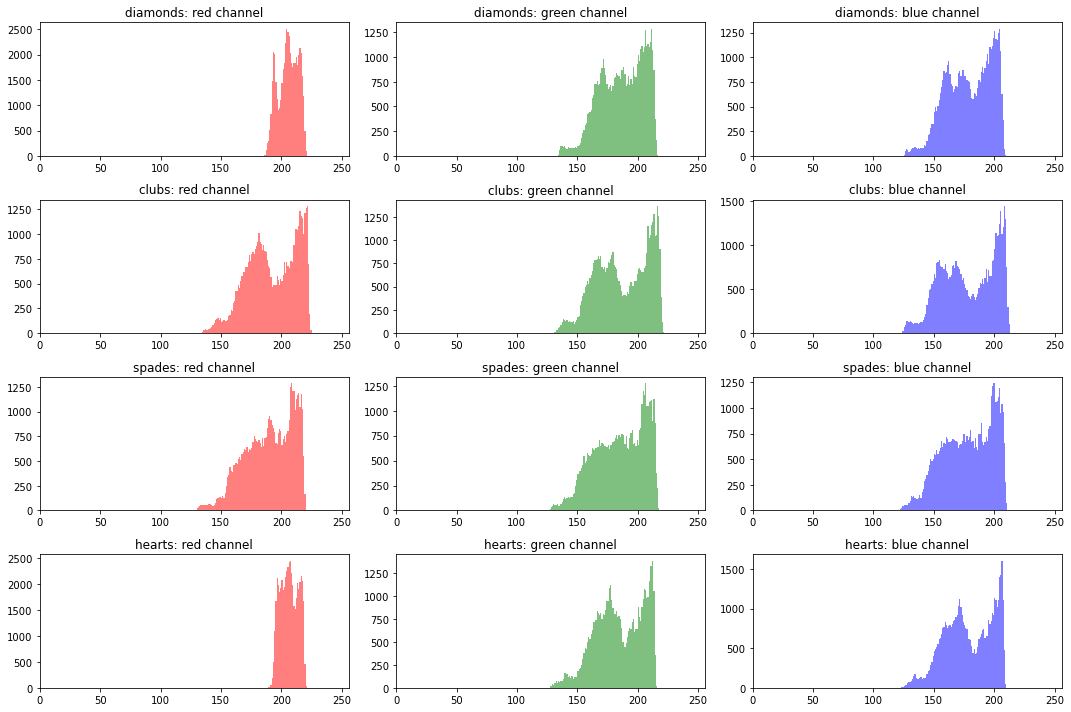

In [8]:
fig, ax = plt.subplots(4, 3, figsize=(15, 10))
for j, item in enumerate(suit_labels):
    ax[j, 0].hist(average_rgb[:, :, 0, j].flatten(), bins=256, range=(0, 256), color='red', alpha=0.5)
    ax[j, 0].set_title(item + ': red channel')
    ax[j, 0].set_xlim([0, 256])

    ax[j, 1].hist(average_rgb[:, :, 1, j].flatten(), bins=256, range=(0, 256), color='green', alpha=0.5)
    ax[j, 1].set_title(item + ': green channel')
    ax[j, 1].set_xlim([0, 256])

    ax[j, 2].hist(average_rgb[:, :, 2, j].flatten(), bins=256, range=(0, 256), color='blue', alpha=0.5)
    ax[j, 2].set_title(item + ': blue channel')
    ax[j, 2].set_xlim([0, 256])

plt.tight_layout()
plt.show()

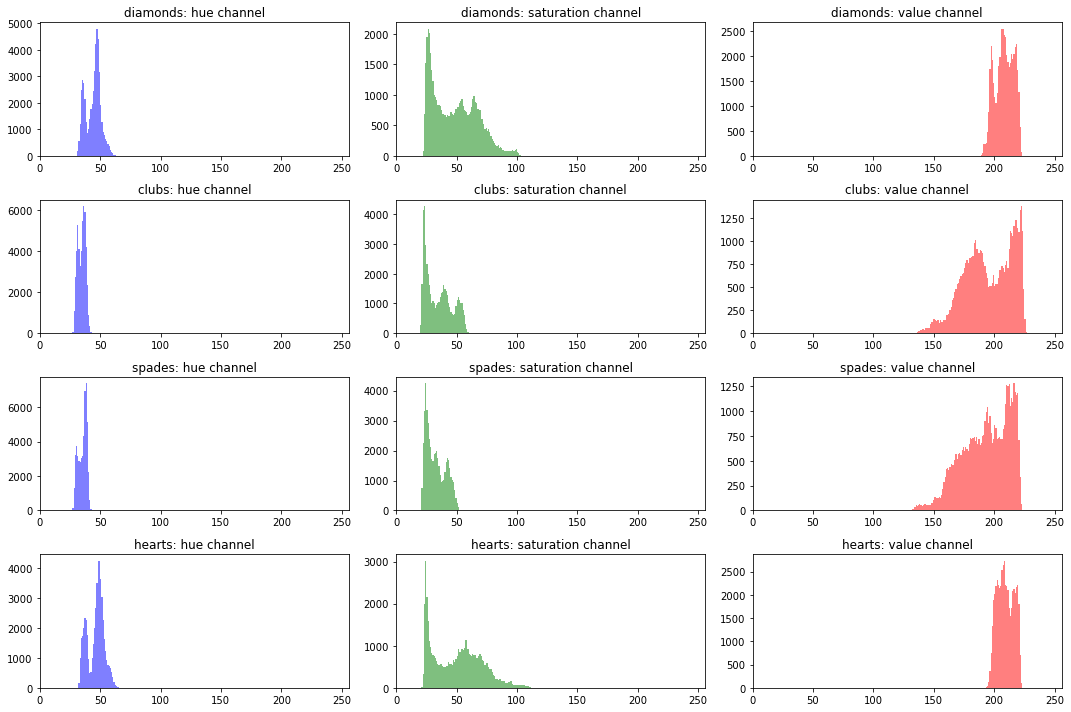

In [9]:
#Hue: The hue component represents the type of color, such as red, blue, green, etc. 

#Saturation: The saturation component represents the intensity or purity of the color. 
#Higher saturation values result in vibrant and vivid colors, while lower saturation values lead to 
#desaturated or grayscale colors. 

#Value: The value component represents the brightness of the color. 
#It determines how light or dark the color appears. 
#A value of 0 indicates black, while a value of 1 (or 100%) indicates full brightness of the color. 
#Intermediate values represent various shades of the hue at different brightness levels.

fig, ax = plt.subplots(4, 3, figsize=(15, 10))
for j, item in enumerate(suit_labels):
    ax[j, 0].hist(average_hsv[:, :, 0, j].flatten(), bins=256, range=(0, 256), color='blue', alpha=0.5)
    ax[j, 0].set_title(item + ': hue channel')
    ax[j, 0].set_xlim([0, 256])

    ax[j, 1].hist(average_hsv[:, :, 1, j].flatten(), bins=256, range=(0, 256), color='green', alpha=0.5)
    ax[j, 1].set_title(item + ': saturation channel')
    ax[j, 1].set_xlim([0, 256])

    ax[j, 2].hist(average_hsv[:, :, 2, j].flatten(), bins=256, range=(0, 256), color='red', alpha=0.5)
    ax[j, 2].set_title(item + ': value channel')
    ax[j, 2].set_xlim([0, 256])

plt.tight_layout()
plt.show()

## SVM Classification

In [40]:
def image_hsv(image):
    # Convert the image from BGR to RGB (matplotlib expects RGB format)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Convert the image from RGB to HSV
    image_hsv = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2HSV)

    return image_hsv

# Function to compute hsv features for a batch of images
def compute_batch_hsv_features(image_generator, channel = 1):
    hsv_features = []
    for _ in range(len(image_generator)):
        image_batch, _ = next(image_generator)  # Get a batch of images (ignore the labels)
        for image in image_batch:
            hsv_features.append(image_hsv(image)[:,:,channel].flatten()) #pull channel 1 for saturation
    return np.array(hsv_features)

### HSV

In [41]:
# Compute HOG features for train, validation, and test sets
train_hsv_features = compute_batch_hsv_features(train_generator,channel = 1)
valid_hsv_features = compute_batch_hsv_features(valid_generator, channel = 1)
test_hsv_features = compute_batch_hsv_features(test_generator, channel = 1)

In [42]:
train_hsv_features.shape


(5138, 50176)

In [43]:
# Create an instance of SVC
classifier = SVC()

# Train the SVC model
classifier.fit(train_hsv_features, train_generator.labels)

# Predict labels for validation data
y_val_pred = classifier.predict(valid_hsv_features)

# Predict labels for test data
y_test_pred = classifier.predict(test_hsv_features)


NameError: name 'accuracy_score' is not defined

In [46]:
# Calculate accuracy scores
val_accuracy = accuracy_score(valid_generator.labels, y_val_pred)
test_accuracy = accuracy_score(test_generator.labels, y_test_pred)

# Print the accuracy scores
print("Validation Accuracy:", val_accuracy)
print("Test Accuracy:", test_accuracy)

Validation Accuracy: 0.2723735408560311
Test Accuracy: 0.2671232876712329


### Template Matching

In [109]:
def template_matching(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    reference_club_image = convert_to_grayscale('train/ace of clubs/083.jpg')
    reference_diamond_image = convert_to_grayscale('train/ace of diamonds/035.jpg')
    reference_heart_image = convert_to_grayscale('train/ace of hearts/026.jpg')
    reference_spade_image = convert_to_grayscale('train/ace of spades/064.jpg')
    
    # Extract templates from reference images
    club_template = reference_club_image[60:170, 50:170]
    diamond_template = reference_diamond_image[60:170, 50:170]
    heart_template = reference_heart_image[60:170, 50:170]
    spade_template = reference_spade_image[60:170, 50:170]

    # Perform template matching for each template
    templates = [club_template, diamond_template, heart_template, spade_template]
    suit_labels = ['Club', 'Diamond', 'Heart', 'Spade']

    best_match_index = -1
    best_match_val = 0.0
    for i, template in enumerate(templates):
        template_images = templates[i]
        print(template_images.shape)
        print()
        result = cv2.matchTemplate(template_images, gray_image, cv2.TM_CCOEFF_NORMED)
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)

        # Check if this match is better than the previous best match
        if max_val > best_match_val:
            best_match_val = max_val
            best_match_index = i

    # Return the index of the best matching suit
    return best_match_index



In [110]:
# Compute HOG features for train, validation, and test sets
train_template_matching_features = compute_batch_template_matching(train_generator)
valid_template_matching_features = compute_batch_template_matching(valid_generator)
test_template_matching_features = compute_batch_template_matching(test_generator)

error: OpenCV(4.7.0) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/templmatch.cpp:1164: error: (-215:Assertion failed) (depth == CV_8U || depth == CV_32F) && type == _templ.type() && _img.dims() <= 2 in function 'matchTemplate'
